In [21]:
import pandas as pd
import torch
from torch import nn, optim, tensor
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import numpy as np

from torch.optim.lr_scheduler import CosineAnnealingLR 

from tqdm import tqdm

import matplotlib.pyplot as plt

from IPython.display import display, clear_output, update_display

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [22]:
from pathlib import Path

In [23]:
dftraining = pd.read_csv(Path('./data/spaceship-titanic/train.csv'))
dftest = pd.read_csv(Path('./data/spaceship-titanic/test.csv'))

In [24]:
dftraining.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [25]:
dftraining.mode()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Earth,False,G/734/S,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,Alraium Disivering,True
1,0002_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ankalik Nateansive,NaN
2,0003_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Anton Woody,NaN
3,0003_02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apix Wala,NaN
4,0004_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asch Stradick,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8689,9278_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8690,9279_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8691,9280_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
dftraining.fillna(dftraining.mode().iloc[0]).isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [27]:
cats = ['HomePlanet', 'Cabin', 'Destination']
conts = ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [337]:
dftraining['Cabin'].str[0].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [338]:
dftraining['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [339]:
def clean_df(df, fillmode='median'):
    df = df.drop(['PassengerId', 'Name'], axis = 1)
    
    df['Cabin_first']= df['Cabin'].str[0]
    df['Cabin_last'] = df['Cabin'].str[-1]
    
    catskeep = [item for item in cats if item != "Cabin"]
    df = df.drop("Cabin", axis=1)
    df = pd.get_dummies(df, columns=catskeep + ['Cabin_first', 'Cabin_last'])
    
    fill_method = getattr(df, fillmode)
    if fillmode == 'mode':
        df = df.fillna(df.mode().iloc[0])
    else:
        df = df.fillna(fill_method())
    
    for cont in conts:
        df[cont] = np.log1p(df[cont].astype(float))
    
    return df

In [340]:
clean_df(dftraining).astype(float).head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,Cabin_first_A,Cabin_first_B,Cabin_first_C,Cabin_first_D,Cabin_first_E,Cabin_first_F,Cabin_first_G,Cabin_first_T,Cabin_last_P,Cabin_last_S
0,0.0,3.688879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,3.218876,0.000000,4.700480,2.302585,3.258097,6.309918,3.806662,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,4.077537,0.693147,3.784190,8.182280,0.000000,8.812248,3.912023,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,3.526361,0.000000,0.000000,7.157735,5.918894,8.110728,5.267858,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,2.833213,0.000000,5.717028,4.262680,5.023881,6.338594,1.098612,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [341]:
def split_df(df, split=0.8):
    train = df.sample(frac=split)
    valid = df.drop(train.index)
    return train, valid

In [343]:
class SpaceTitanic(Dataset):
    def __init__(self, df, fillmode='median', train=True, device='cpu'):
        self.train = train
        self.clean_ds = clean_df(df, fillmode)

        self.device = device
        
    def __getitem__(self, i):
        row = self.clean_ds.iloc[i].astype(np.float32)
        if not self.train: return tensor(row).to(self.device)
        x = tensor(row.drop(labels=['Transported']))
        y = tensor(row.loc(axis=0)['Transported'])
        return (x.to(self.device), y.to(self.device))
        
    def __len__(self):
        return len(self.clean_ds)

In [518]:
class Block(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm1d(n_in),
            nn.Linear(n_in, n_out),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3)
        )
        
    def forward(self, x):
        return self.net(x)

class SpaceTitanicModel(nn.Module):
    def __init__(self, n_in, n_out, n_h, n_hidden_layers=5):
        super().__init__()
        self.first = nn.Linear(n_in, n_h)
        self.proj_in_h = nn.Linear(n_in, n_h)
        self.blocks = nn.Sequential(
            *[Block(n_h, n_h) for i in range(n_hidden_layers)],
        )
        self.last_norm = nn.BatchNorm1d(n_h)
        self.last = nn.Linear(n_h, n_out, bias=False)
        
    def forward(self, x):
        x = self.first(x) + self.proj_in_h(x) # bs, nh + bs, n_h
        for m in self.blocks:
            x = m(x) + x
            
        return self.last(self.last_norm(x))

In [519]:
def normalize(tns, dim=0): return (tns - tns.mean(dim=dim, keepdim=True)) / tns.std(dim=dim, keepdim=True)

In [520]:
class Learner():
    def __init__(self, model, dls, opt, sched, loss_fn=F.mse_loss, device='cpu'):
        self.model = model.to(device)
        self.dls = dls
        self.opt = opt
        self.loss_fn = loss_fn
        self.sched = sched
        
    def fit(self, epochs=1, plot=True):
        self.losses_train = []
        self.losses_val = []
        self.plot = plot
        self.epochs = epochs
        
        self.fig, self.ax = plt.subplots()
        plt.tight_layout()
        
        display(self.fig, display_id='plot')
        for self.epoch in tqdm(range(epochs)):
            self._fit(True)
            torch.no_grad()(self._fit(False))
            
        if self.plot:
            self.ax.plot(self.losses_train, color="blue", linestyle="-")
            val_pos = [len(self.dls[0]) * (i + 1) for i in range(self.epoch + 1)]
            self.ax.plot(val_pos, self.losses_val, color="orange", linestyle="--")
            self.fig.canvas.draw()
            update_display(self.fig, display_id='plot')

                
    def _fit(self, train=True):
        self.model.train() if train else self.model.eval()
        dl = self.dls[0] if train else self.dls[1]
        loss_val = 0.0
        for x, y in dl:
            x = normalize(x, dim=1)
            pred = self.model(x)
            pred = pred.view(-1)
            loss = self.loss_fn(pred, y)
            if train:
                loss.backward()
                self.opt.step()
                self.opt.zero_grad()
                self.sched.step()
                self.losses_train.append(loss.item())
                if self.plot:
                    self.ax.clear()
                    
                    self.ax.plot(self.losses_train, color="blue", linestyle="-")
                    val_pos = [len(self.dls[0]) * (i + 1) for i in range(self.epoch)]
                    self.ax.plot(val_pos, self.losses_val, color="orange", linestyle="-")
                    
                    self.fig.canvas.draw()
                    update_display(self.fig, display_id='plot')

            else:
                loss_val += loss.item() * x.shape[0]
                
        if not train:
            loss_val_avg = loss_val / len(dsvalid)
            self.losses_val.append(loss_val_avg)


In [521]:
class Metrics:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.vals, self.ns = [], []
        
    def add(self, inp, targets=None, n=1):
        self.last = self.calc(inp, targets)
        self.vals.append(self.last)
        self.ns.append(n)
    
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals) * ns).sum() / np.sum(self.ns)
    
    def calc(self, inp, targets):
        return inp

In [522]:
class Accuracy(Metrics):
    def __init__(self):
        super().__init__()
    
    def calc(self, inp, targets):
        return (inp == targets).float().mean()

In [523]:
def init_model(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, a=0.1)
        if m.bias is not None: nn.init.constant_(m.bias, 0.0)

In [524]:
dftrain, dfvalid = split_df(dftraining, split=0.9)

In [525]:
dfvalid.shape

(869, 14)

In [526]:
clean_df(dfvalid).shape, clean_df(dftrain).shape

((869, 25), (7824, 25))

In [527]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dstrain, dsvalid = SpaceTitanic(dftrain, fillmode="mode", device=device), SpaceTitanic(dfvalid, fillmode="mode", device=device)

dsvalid.clean_ds = dsvalid.clean_ds.reindex(columns=dstrain.clean_ds.columns, fill_value=0)
dstrain.clean_ds.shape, dsvalid.clean_ds.shape

((7824, 25), (869, 25))

In [537]:
bs = 128
dls = DataLoader(dstrain, batch_size=bs, drop_last=True), DataLoader(dsvalid, batch_size=bs, drop_last=True)
n_features = dstrain.clean_ds.shape[1] - 1

model = SpaceTitanicModel(n_features, 1, 1000, 1000)
model.apply(init_model)

lr = 5e-5
opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)
n_epochs = 15
sched = CosineAnnealingLR(opt, n_epochs * len(dls), lr * 0.5)

In [538]:
learn = Learner(model, dls, loss_fn=F.binary_cross_entropy_with_logits, opt=opt, sched=sched, device=device)

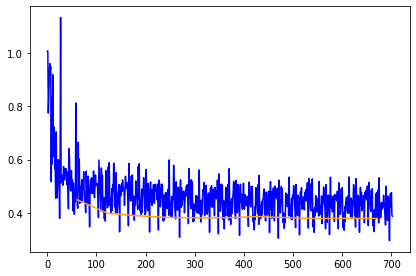

 73%|███████▎  | 11/15 [02:25<00:52, 13.21s/it]


KeyboardInterrupt: 

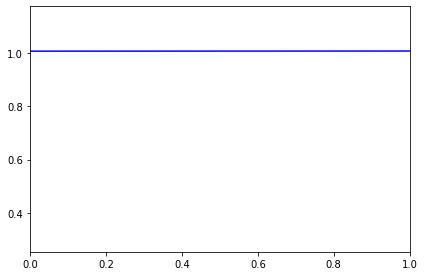

In [539]:
learn.fit(n_epochs)

In [476]:
dstest = SpaceTitanic(dftest, train=False, device=device)
dltest = DataLoader(dstest, batch_size=1024)iii

In [491]:
preds = None

model.eval()
with torch.no_grad():
    for x in dltest:
        x = normalize(x, dim=1)
        out = learn.model(x)
        probs = F.sigmoid(out)
        if preds is None: preds = probs.round()
        else: preds = torch.cat((preds, probs.round()))

In [492]:
preds = preds.squeeze()

In [493]:
dfsubmit = pd.DataFrame()

In [494]:
dfsubmit['PassengerId'] = dftest['PassengerId']

In [495]:
dfsubmit['Transported'] = torch.randint(0, 2, (dftest.shape[0],)).to(bool)

In [496]:
dfsubmit

,PassengerId,Transported
0,0013_01,True
1,0018_01,True
2,0019_01,False
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [497]:
dfsubmit.to_csv("spaceship_submit.csv", index=False)

In [490]:
dstest.clean_ds

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Cabin_first_A,Cabin_first_B,Cabin_first_C,Cabin_first_D,Cabin_first_E,Cabin_first_F,Cabin_first_G,Cabin_first_T,Cabin_last_P,Cabin_last_S
0,0.693147,3.332205,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,...,0,0,0,0,0,0,1,0,0,1
1,0.000000,2.995732,0.0,0.000000,2.302585,0.000000,7.945910,0.000000,1,0,...,0,0,0,0,0,1,0,0,0,1
2,0.693147,3.465736,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,...,0,0,1,0,0,0,0,0,0,1
3,0.000000,3.663562,0.0,0.000000,8.802823,0.000000,5.204007,6.373320,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0.000000,3.044522,0.0,2.397895,0.000000,6.455199,0.000000,0.000000,1,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.693147,3.555348,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,...,0,0,0,0,0,0,1,0,0,1
4273,0.000000,3.761200,0.0,0.000000,6.742881,2.890372,2.397895,4.976734,1,0,...,0,0,0,0,0,0,0,0,0,0
4274,0.693147,3.295837,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0,0,0,1,0,0,0,0,1,0
4275,0.000000,3.295837,0.0,0.000000,7.893945,0.000000,0.000000,6.261492,0,1,...,0,0,0,1,0,0,0,0,1,0
